# Importing Franke's function
Including a plot

# My notes:
- b and d: leave intercept out
- when to use sudo

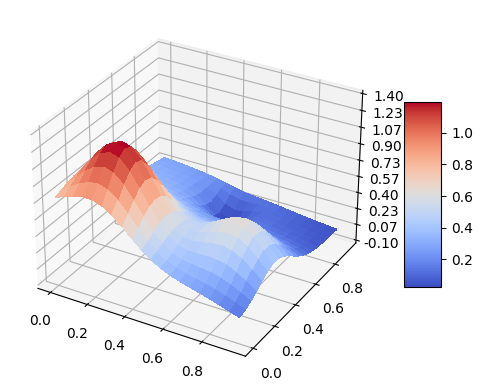

In [12]:
%reset -f

%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
import pandas as pd

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Generate the data
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Exercise a)

In this exercise, we only applied limited scaling of the data by removing the intercept. Removing the intercept mainly aims to make the code more in line with the following codes for the Ridge and Lasso Regression, where removing the intercept has an impact on the cost function.
Since our produced data is evenly distributed in the intervall [0,1), there is no need to identify outliers.

We perform splitting the data in test and train data once, and then apply the OLS fitting with polynomials for each degree. The uniformly splitting of the data allows us a better comparison of the MSEs later on.

with stochastic input/ with linspace -> Satz von Peano ;)


In [13]:
def rsquare(y, ypredict):
    return 1-np.sum((y-ypredict)**2)/np.sum((y-np.mean(y))**2)

def MSE(y, ypredict):
    return 1/len(y)*(y.T-ypredict.T) @ (y-ypredict)

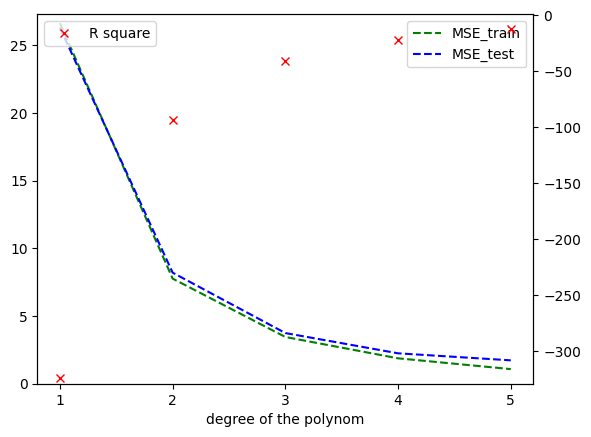

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

# degree of the fitted polynomial
degree = 5

# setting up the Designmatrix
x = x.reshape(-1,1) #reshaping the meshgrid in two arrays
y = y.reshape(-1,1)
z = z.reshape(-1,1)

def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

X = create_X(x,y,degree)

# scaling / centering of the data
intercept = np.mean(X[:,0])
X = X[:,1:len(X)]
z = z - intercept

# splitting in train and test
X_train, X_test, z_train, z_test = train_test_split( X, z, test_size=0.33, random_state=42)


# OLS fitting without stochastic noise

beta_list = []
MSE_train = np.zeros(degree)
MSE_test = np.zeros(degree)
rsqr = np.zeros(degree)

for i in range(1, degree+1):
        c = int((i+2)*(i+1)/2)
        X_tilde = X_train[:,0:c-1]
        beta = np.linalg.pinv(X_tilde.T @ X_tilde) @ X_tilde.T @ z_train
        beta_list.append(list(beta))
		
        ypredict = X_tilde @ beta
        ypredict_test = X_test[:,0:c-1] @ beta

        MSE_train[i-1] = MSE(z_train, ypredict)
        MSE_test[i-1] = MSE(z_test, ypredict_test)
        rsqr[i-1]= rsquare(z_train, ypredict)

# MSE and R^2
# plot the MSE and R^2 - as well as beta - as functions of the polynomial degree
fig2, ax1 = plt.subplots()
plt.xlabel("degree of the polynom")
xax = np.arange(1, degree +1)
plt.xticks(xax)
ax2 = ax1.twinx()
ax2.set_ylim(np.min(rsqr)-5, 1)
ax1.set_ylim(0, np.max(MSE_test)+1)
ax1.plot(xax, MSE_train, 'g--', label='MSE_train')
ax1.plot(xax, MSE_test, 'b--', label='MSE_test')
ax2.plot(xax, rsqr, 'rx', label='R square')
ax1.legend()
ax2.legend()

#ax = fig.add_subplot(projection='3d')
#ax2.set_ylabel("degree of the polynom")


In [15]:
# with stochastic noise



# Exercise b) Ridge

ValueError: x and y must have same first dimension, but have shapes (5,) and (6, 5)

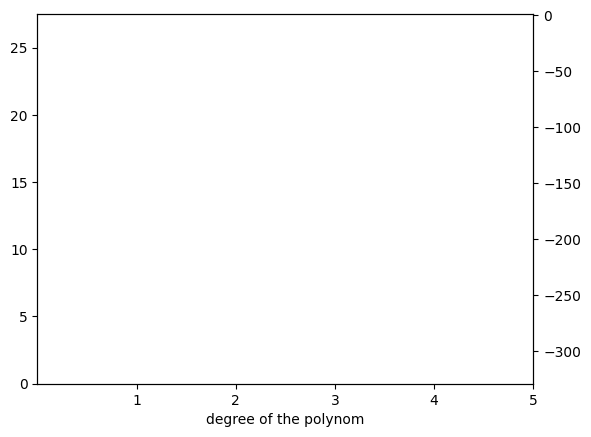

In [30]:
lambda_ = np.append([0],[0.0001*10**i for i in range(0,5)])

beta_list = []
MSE_train = np.zeros((len(lambda_),degree))
MSE_test = np.zeros((len(lambda_),degree))
rsqr = np.zeros((len(lambda_),degree))

for j in range(0, len(lambda_)):

    for i in range(1, degree+1):
        c = int((i+2)*(i+1)/2)
        X_tilde = X_train[:,0:c-1]
        beta = np.linalg.pinv(X_tilde.T @ X_tilde + lambda_[j]*np.ones((len(X_tilde.T),len(X_tilde.T)))) @ X_tilde.T @ z_train
        beta_list.append(list(beta))
		
        ypredict = X_tilde @ beta
        ypredict_test = X_test[:,0:c-1] @ beta

        MSE_train[j, i-1] = MSE(z_train, ypredict)
        MSE_test[j, i-1] = MSE(z_test, ypredict_test)
        rsqr[j, i-1]= rsquare(z_train, ypredict)

# MSE and R^2
# plot the MSE and R^2 - as well as beta - as functions of the polynomial degree
fig2, ax1 = plt.subplots()
plt.xlabel("degree of the polynom")
xax = np.arange(1, degree +1)
plt.xticks(xax)
ax2 = ax1.twinx()
ax2.set_ylim(np.min(rsqr)-5, 1)
ax1.set_ylim(0, np.max(MSE_test)+1)
ax1.plot(xax, MSE_train, 'g--', label='MSE_train')
ax1.plot(xax, MSE_test, 'b--', label='MSE_test')
ax2.plot(xax, rsqr, 'rx', label='R square')
ax1.legend()
ax2.legend()

#ax = fig.add_subplot(projection='3d')
#ax2.set_ylabel("degree of the polynom")


# Exercise c)